In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [2]:
pd.set_option('display.max_columns', 60)
myData=pd.read_csv('imputedData.csv')
myData.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
#One hot encoding of categorical variables

#Create list with features to be dummified cols.
nonum_feats_names = ['Month','OperatingSystems','Browser','Region','VisitorType','Weekend']


dataModel = pd.concat([myData[['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 
                              'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues',
                               'TrafficType','SpecialDay']],
                       pd.get_dummies(myData[nonum_feats_names].astype('category')),myData['Revenue']],axis=1)
                      
dataModel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 57 columns):
Administrative                   12330 non-null int64
Administrative_Duration          12330 non-null float64
Informational                    12330 non-null int64
Informational_Duration           12330 non-null float64
ProductRelated                   12330 non-null int64
ProductRelated_Duration          12330 non-null float64
BounceRates                      12330 non-null float64
ExitRates                        12330 non-null float64
PageValues                       12330 non-null float64
TrafficType                      12330 non-null int64
SpecialDay                       12330 non-null float64
Month_Aug                        12330 non-null uint8
Month_Dec                        12330 non-null uint8
Month_Feb                        12330 non-null uint8
Month_Jul                        12330 non-null uint8
Month_June                       12330 non-null uint8
Month_Mar    

In [4]:
#Label Encoding of revenue

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
myData['Revenue'] = le.fit_transform(myData['Revenue'])
myData['Revenue'].value_counts()

myData['Revenue'].head()

# getting dependent and independent variables

x = dataModel
# removing the target column revenue from x
x = x.drop(['Revenue'], axis = 1)

y = myData['Revenue']

# checking the shapes
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

Shape of x: (12330, 56)
Shape of y: (12330,)


In [5]:
# splitting the data

from sklearn.model_selection import train_test_split

x_baseTrain, x_baseTest, y_baseTrain, y_baseTest = train_test_split(x, y, test_size = 0.3, random_state = 42)

# checking the shapes

print("Shape of x_train :", x_baseTrain.shape)
print("Shape of y_train :", y_baseTrain.shape)
print("Shape of x_test :", x_baseTest.shape)
print("Shape of y_test :", y_baseTest.shape)

Shape of x_train : (8631, 56)
Shape of y_train : (8631,)
Shape of x_test : (3699, 56)
Shape of y_test : (3699,)


In [6]:
#SCALING WITH STANDARD Z SCORE SCALER
#Scaling the data first fitting it and transforming the training set
#to later apply the fit to transform the test set.
from sklearn.preprocessing import StandardScaler

num_cols_names = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 
                              'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues',
                               'TrafficType','SpecialDay']

#Instantiate Satandard Scaler
scaler = StandardScaler()
#Fit transform the numerical features in the training dataset to a new dataframe
scaled_numfeats_train = pd.DataFrame(scaler.fit_transform(x_baseTrain[num_cols_names]), 
                                     columns=num_cols_names, index= x_baseTrain.index)
#Integrate scaled values to the training set
for col in num_cols_names:
    x_baseTrain[col] = scaled_numfeats_train[col]
    
    
#Transform the numerical features inthe training dataset to a new dataframe
scaled_numfeats_test = pd.DataFrame(scaler.transform(x_baseTest[num_cols_names]),
                                    columns=num_cols_names, index= x_baseTest.index)
#Integrate scaled values to the test set
for col in num_cols_names:
    x_baseTest[col] = scaled_numfeats_test[col]

C:\Users\neera\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\neera\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit. Applying this feature selection on corr fixed data

In [7]:
x_baseTrain.drop(labels=['Browser_1','BounceRates','ProductRelated','VisitorType_Returning_Visitor'], 
                 axis=1, inplace=True)
x_baseTest.drop(labels=['Browser_1','BounceRates','ProductRelated','VisitorType_Returning_Visitor'], 
                axis=1, inplace=True)

x_baseTrain.shape, x_baseTest.shape

C:\Users\neera\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((8631, 52), (3699, 52))

In [13]:
# step forward feature selection
# I indicate that I want to select 25 features from
# the total, and that I want to select those features
# based on the optimal roc_auc
import warnings
warnings.filterwarnings('ignore')

sfs1 = SFS(RandomForestClassifier(n_jobs=4), 
           k_features=25, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=3)

sfs1 = sfs1.fit(np.array(x_baseTrain), y_baseTrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:   21.3s finished

[2020-03-22 09:30:03] Features: 1/25 -- score: 0.7702556935421193[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:   19.7s finished

[2020-03-22 09:30:23] Features: 2/25 -- score: 0.8376859562775015[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   20.4s finished

[2020-03-22 09:30:44] Features: 3/25 -- score: 0.8569163170899469[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

# Step Forward Selection Top 25

In [14]:
selected_feat= x_baseTrain.columns[list(sfs1.k_feature_idx_)]
selected_feat

Index(['Administrative', 'Administrative_Duration', 'Informational_Duration',
       'ProductRelated_Duration', 'ExitRates', 'PageValues', 'TrafficType',
       'Month_Feb', 'Month_Jul', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Browser_2', 'Browser_3', 'Browser_4', 'Browser_6', 'Browser_8',
       'Browser_9', 'Browser_12', 'Browser_13', 'Region_3', 'Region_4',
       'Region_6', 'VisitorType_Other', 'Weekend_False'],
      dtype='object')

In [23]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

(<Figure size 1440x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19c6386a9c8>)

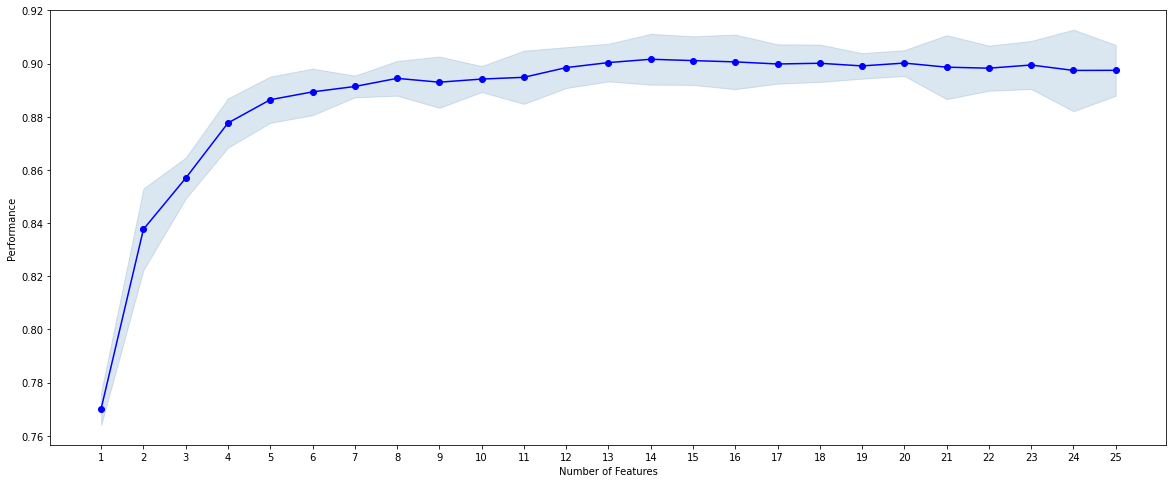

In [34]:
#checking performance
plot_sfs(sfs1.get_metric_dict(), kind='std_dev',figsize=(20, 8))

Now doing Step backward selection

In [16]:
# step backward feature selection
# I indicate that I want to select 25 features from
# the total, and that I want to select those features
# based on the optimal roc_auc

sfs2 = SFS(RandomForestClassifier(n_jobs=4), 
           k_features=25, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=3)

sfs2 = sfs2.fit(np.array(x_baseTrain), y_baseTrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:   25.4s finished

[2020-03-22 10:09:17] Features: 51/25 -- score: 0.8942600068168423[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:   24.9s finished

[2020-03-22 10:09:42] Features: 50/25 -- score: 0.895332923043589[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   24.3s finished

[2020-03-22 10:10:06] Features: 49/25 -- score: 0.8958618205928058[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

# Step Backward Selection Top 25

In [17]:
selected_featbk= x_baseTrain.columns[list(sfs2.k_feature_idx_)]
selected_featbk

Index(['Administrative_Duration', 'Informational_Duration',
       'ProductRelated_Duration', 'ExitRates', 'PageValues', 'SpecialDay',
       'Month_Dec', 'Month_Jul', 'Month_May', 'Month_Nov', 'Month_Oct',
       'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2',
       'OperatingSystems_5', 'OperatingSystems_6', 'Browser_7', 'Browser_8',
       'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12', 'Region_2',
       'Region_4', 'Weekend_False'],
      dtype='object')

Next we will do Exhaustive feature selection

(<Figure size 1440x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19c63c4f148>)

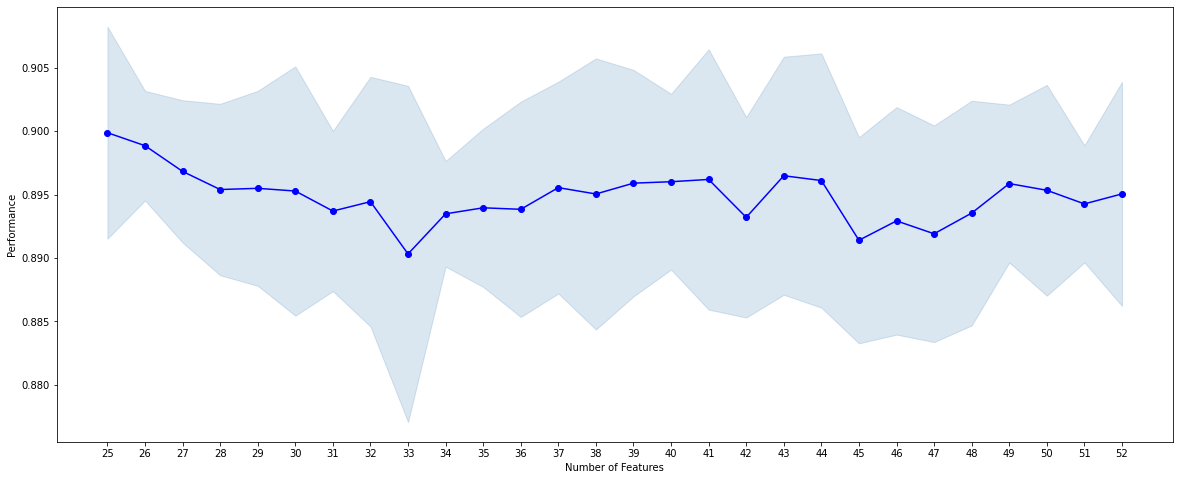

In [35]:
#checking performance
plot_sfs(sfs2.get_metric_dict(), kind='std_dev',figsize=(20, 8))

In [19]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [44]:
x_baseTrain.columns[0:10]

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated_Duration', 'ExitRates',
       'PageValues', 'TrafficType', 'SpecialDay', 'Month_Aug'],
      dtype='object')

In [45]:
# exhaustive feature selection
# I indicate that I want to select 15 features from
# the total, and that I want to select those features
# based on the optimal roc_auc

# in order to shorter search time for the demonstration
# i will ask the algorithm to try all possible 1,2,3,....10
# feature combinations from a dataset of 10 features

# if you have access to a multicore or distributed computer
# system you can try more greedy searches

efs1 = EFS(RandomForestClassifier(n_jobs=4, random_state=0), 
           min_features=1,
           max_features=10, 
           scoring='roc_auc',
           print_progress=True,
           cv=2)

efs1 = efs1.fit(np.array(x_baseTrain[x_baseTrain.columns[0:10]]), y_baseTrain) 

Features: 1023/1023

# EFS Top Features

In [46]:
efs1.best_idx_
selected_featEFS= x_baseTrain.columns[list(efs1.best_idx_)]
selected_featEFS

Index(['Administrative', 'Informational_Duration', 'ProductRelated_Duration',
       'ExitRates', 'PageValues', 'TrafficType', 'SpecialDay'],
      dtype='object')

(<Figure size 1440x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19c63019dc8>)

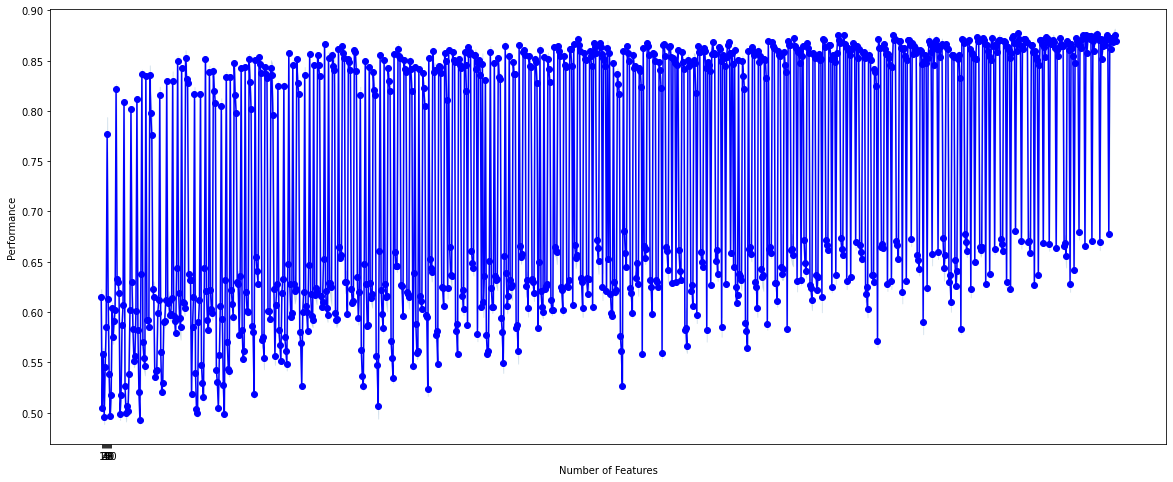

In [47]:
#checking performance
plot_sfs(efs1.get_metric_dict(), kind='std_dev',figsize=(20, 8))